## Patching 3D

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from pympler import asizeof
from pylops.signalprocessing.patch3d import patch3d_design
from pylops.utils.dottest import dottest

from pylops.signalprocessing import Patch3D
from patch3dol import Patch3D as Patch3DOLD
from visual import explode_volume

USE_CUPY = False

In [2]:
if USE_CUPY:
    import cupy as np
    from cupyx.profiler import benchmark
    np_asarray = np.asarray
    np_asnumpy = np.asnumpy
    np_float = np.float32
    np_floatc = np.complex64
    mempool = np.get_default_memory_pool()
    fftengine = 'numpy'
    fftkwargs = dict()
else:
    np_asarray = np.asarray
    np_asnumpy = np.asarray
    np_float = np.float64
    np_floatc = np.complex128
    fftengine = 'scipy'
    fftkwargs = dict(workers=16)

In [3]:
def bench_Op(Op, x):
    return Op @ x

def bench_OpH(Op, x):
    return Op.H @ x

In [4]:
savetaper = False
tapertype = 'cosine'

In [5]:
nwin = (42, 42, 34)
nover = (10, 10, 4)
nop = (64, 64, 64)
dimsd = (500, 100, 200) # small
dimsd = (490, 74, 184) # small with no edges
#dimsd = (1000, 500, 500) # large

y = np.random.normal(0., 1., dimsd[0]*dimsd[1]*dimsd[2]).reshape(dimsd).astype(np_float)

nwins, dims, mwin_inends, dwin_inends = patch3d_design(dimsd, nwin, nover, nop)

# no operator broadcast
Op = pylops.signalprocessing.FFTND(nwin, nffts=nop, 
                                   engine=fftengine, 
                                   dtype=np_floatc, 
                                   **fftkwargs)
Slid = Patch3DOLD(Op.H, dims, dimsd, nwin, nover, nop, tapertype=tapertype)
Slid1a = Patch3D(Op.H, dims, dimsd, nwin, nover, nop, tapertype=tapertype, savetaper=savetaper)

# with operator broadcast
Op = pylops.signalprocessing.FFTND((*nwins, *nwin), nffts=nop, 
                                   engine=fftengine,
                                   dtype=np_floatc, 
                                   **fftkwargs)
Slid1b = Patch3D(Op.H, dims, dimsd, nwin, nover, nop, tapertype=tapertype, savetaper=savetaper)

x = Slid.H * y.ravel()

In [6]:
print(np.allclose(Slid @ x, Slid1a @ x), np.allclose(Slid.H @ y, Slid1a.H @ y))
print(np.allclose(Slid @ x, Slid1b @ x), np.allclose(Slid.H @ y, Slid1b.H @ y))

True True
True True


In [7]:
if not USE_CUPY:
    %timeit -n 5 -r 10 Slid * x # OLD
    %timeit -n 5 -r 10 Slid1a * x # NEW
    %timeit -n 5 -r 10 Slid1b * x # NEW with Op broadcasted
else:
    print(benchmark(bench_Op, (Slid, x,), n_repeat=20))
    print(benchmark(bench_Op, (Slid1a, x,), n_repeat=20))
    print(benchmark(bench_Op, (Slid1b, x,), n_repeat=20))

886 ms ± 53.7 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
407 ms ± 10.4 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
654 ms ± 39.4 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [8]:
if not USE_CUPY:
    %timeit -n 5 -r 10 Slid.H * y # OLD
    %timeit -n 5 -r 10 Slid1a.H * y # NEW
    %timeit -n 5 -r 10 Slid1b.H * y # NEW with Op broadcasted
else:
    print(benchmark(bench_OpH, (Slid, y,), n_repeat=20))
    print(benchmark(bench_OpH, (Slid1a, y,), n_repeat=20))
    print(benchmark(bench_OpH, (Slid1b, y,), n_repeat=20))

770 ms ± 17 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
588 ms ± 46.8 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
405 ms ± 4.63 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [9]:
print(asizeof.asizeof(Slid) * 1e-6, asizeof.asizeof(Slid1a) * 1e-6, asizeof.asizeof(Slid1b) * 1e-6) 

17.570439999999998 25.921432 25.921608


In [10]:
# Check that the results with and without the savetaper are the same
nwin = (42, 42, 34)
nover = (10, 10, 4)
nop = (64, 64, 64)
#dimsd = (500, 100, 200) # small
dimsd = (490, 106, 184) # small with no edges
#dimsd = (1000, 500, 500) # large
tapertype='cosine'

nwins, dims, mwin_inends, dwin_inends = patch3d_design(dimsd, nwin, nover, nop)

# no operator broadcast
Op = pylops.signalprocessing.FFTND(nwin, nffts=nop, 
                                   engine=fftengine, 
                                   dtype=np_floatc, 
                                   **fftkwargs)

Slid = Patch3DOLD(Op.H, dims, dimsd, nwin, nover, nop, tapertype=tapertype)
Slid1a = Patch3D(Op.H, dims, dimsd, nwin, nover, nop, tapertype=tapertype, savetaper=True)
Slid1ano = Patch3D(Op.H, dims, dimsd, nwin, nover, nop, tapertype=tapertype, savetaper=False)

# with operator broadcast
Op = pylops.signalprocessing.FFTND((*nwins, *nwin), nffts=nop, 
                                   engine=fftengine,
                                   dtype=np_floatc, 
                                   **fftkwargs)
Slid1b = Patch3D(Op.H, dims, dimsd, nwin, nover, nop, tapertype=tapertype, savetaper=True)
Slid1bno = Patch3D(Op.H, dims, dimsd, nwin, nover, nop, tapertype=tapertype, savetaper=False)

y = np.random.normal(0., 1., dimsd[0]*dimsd[1]*dimsd[2]).reshape(dimsd).astype(np_float)

x = Slid1a.H * y.ravel()
x1 = Slid1ano.H * y.ravel()

In [11]:
dottest(Slid1a), dottest(Slid1ano)

(True, True)

(True, True)

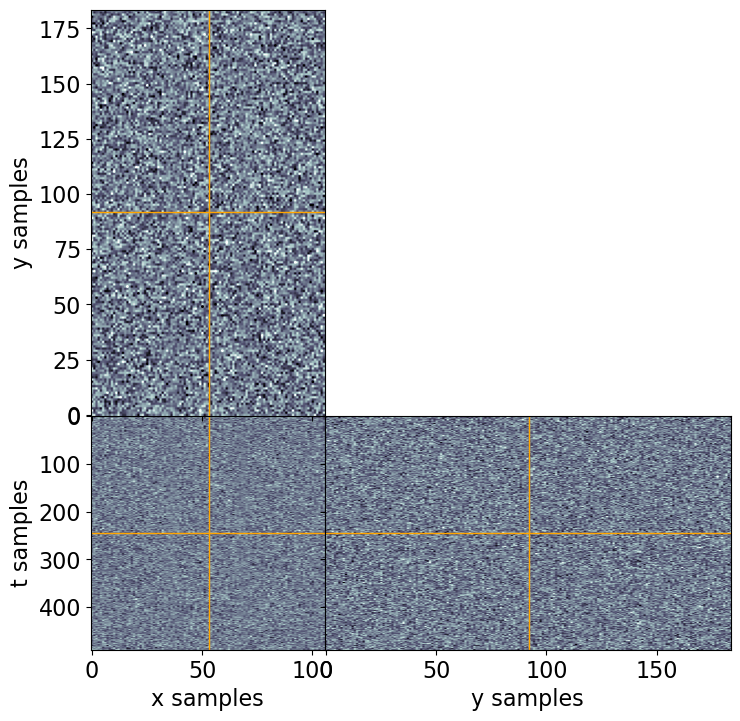

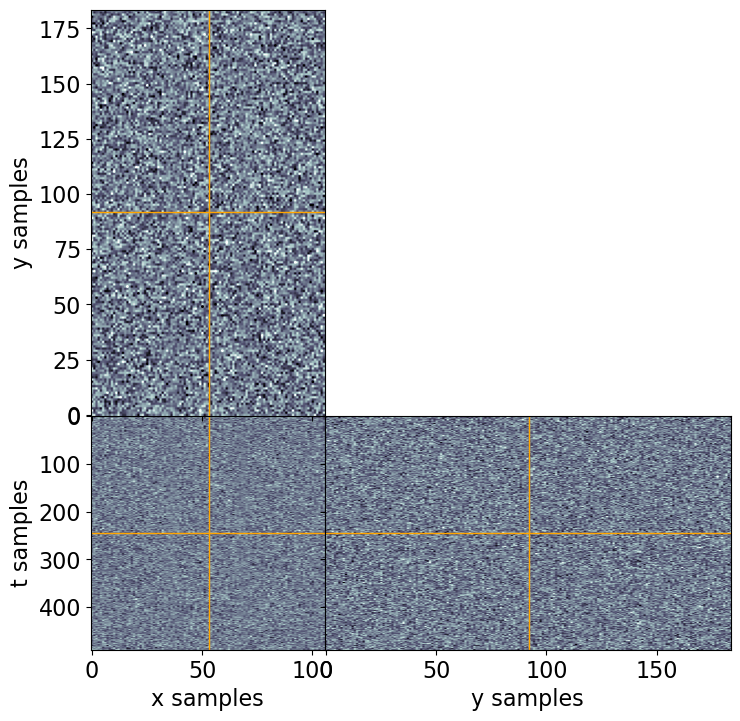

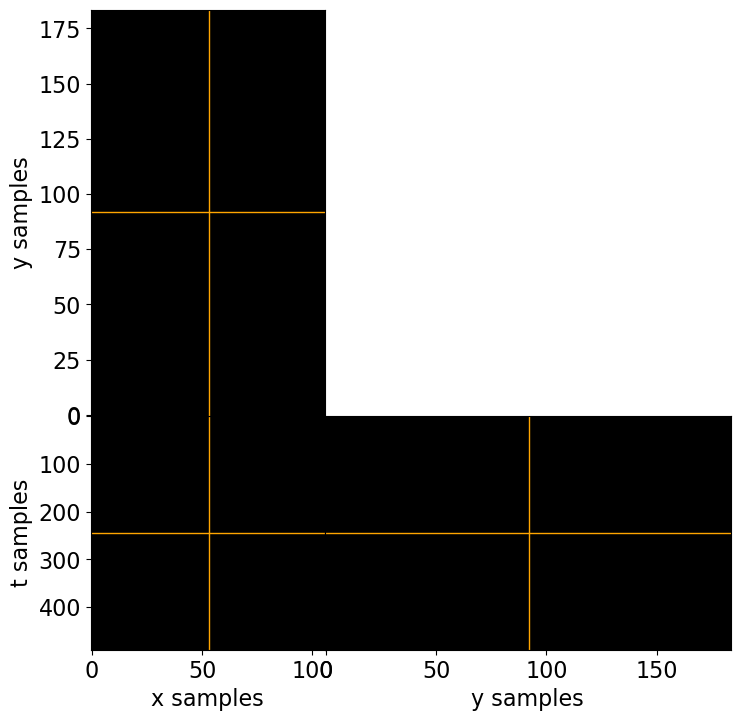

In [12]:
x = np.random.normal(0, 1, Slid1a.dims).astype(np_float)
# x = np.ones(Slid1a.dims).astype(np_float)

y0 = Slid @ x
y = Slid1a @ x
y1 = Slid1ano * x

explode_volume(y.real)
explode_volume(y1.real)
explode_volume(y.real - y1.real)

np.allclose(y0, y), np.allclose(y, y1)

(True, True)

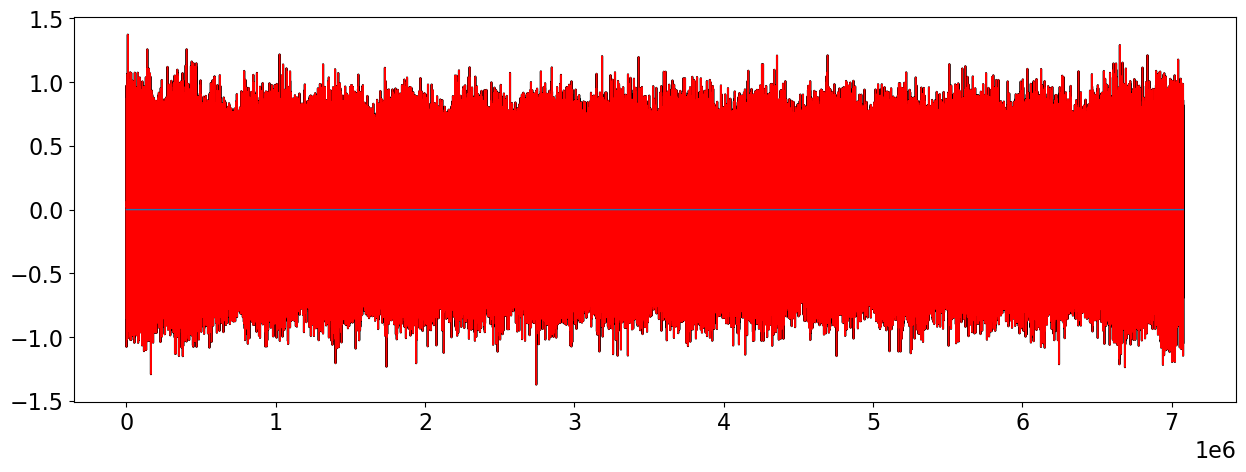

In [13]:
y = np.random.normal(0., 1., dimsd[0]*dimsd[1]*dimsd[2]).reshape(dimsd).astype(np_float)

x0 = Slid.H * y.ravel()
x = Slid1a.H * y.ravel()
x1 = Slid1ano.H * y.ravel()

plt.figure(figsize=(15, 5))
plt.plot(x.ravel()[::10], 'k')
plt.plot(x1.ravel()[::10], 'r', lw=1)
plt.plot((x.ravel()-x1.ravel())[::10], lw=1)

np.allclose(x0, x), np.allclose(x, x1)

In [14]:
print(np.allclose(Slid1a @ x, Slid1ano @ x), np.allclose(Slid1a.H @ y, Slid1ano.H @ y))
print(np.allclose(Slid1b @ x, Slid1bno @ x), np.allclose(Slid1b.H @ y, Slid1bno.H @ y))

True True
True True


In [15]:
print(asizeof.asizeof(Slid1a) * 1e-6, asizeof.asizeof(Slid1ano) * 1e-6, 
      asizeof.asizeof(Slid1b) * 1e-6, asizeof.asizeof(Slid1bno) * 1e-6) 

259.10893599999997 25.922103999999997 259.109112 25.922279999999997
